In [2]:
import csv
import re
import numpy as np
import pandas as pd
import torch
import torchvision
from torch.utils.data import DataLoader
from torch.utils.data import random_split
import torch.nn.functional as F

## Loading the data

In [3]:
torch.cuda.is_available()
device = torch.device("cuda")

In [4]:
from google.colab import drive
drive.mount('/content/drive')
!ls '/content/drive/MyDrive/eth_CS4NLP/project/qadata'

Mounted at /content/drive
vardial_dev.gdoc  vardial_train_1.csv  vardial_train.gsheet
vardial_dev.txt   vardial_train_2.csv


#### IMPORT devset

In [5]:
train_path = '/content/drive/MyDrive/eth_CS4NLP/project/qadata/vardial_train_2.csv'
dev_path = '/content/drive/MyDrive/eth_CS4NLP/project/qadata/vardial_dev.txt'

In [6]:
#todo: rewrite function, rename list of label
#IMPORT devset
dial_label = {
    0 : 'EML',
    1 : 'NAP',
    2 : 'PMS',
    3 : 'FUR',
    4 : 'LLD',
    5 : 'LIJ',
    6 : 'LMO',
    7 : 'ROA_TARA',
    8 : 'SCN', 
    9 : 'VEC',
    10 : 'SC'
}

fold_label = {
    'EML' : 0,
    'NAP' : 1,
    'PMS' : 2,
    'FUR' : 3,
    'LLD' : 4,
    'LIJ' : 5,
    'LMO' : 6,
    'ROA_TARA' : 7,
    'SCN' : 8,
    'VEC' : 9,
    'SC' : 10
}

def explain_label(label : int) -> str:
    """ 
    Given an integer label, convert it to the corresponding string label
    :param int label: integer label to be converted
    :return: string corresponding to the given label
    """
    return dial_label[label]

def encode_label(label : str) -> int:
    """ 
    Given a string label, encode it to the corresponding index
    :param string label: string label to be converted
    :return: int corresponding to the given label
    """
    return fold_label[label]

In [7]:
df_dev = pd.read_csv(dev_path, sep = "\t", names=["label", "text"])
df_dev['label'] = df_dev['label'].apply(encode_label)
df_dev = df_dev.fillna('') #convert nan float to emtry string
df_dev.head(10)

,label,text
0,6,"Ma te see foeura de coo, ò te me toeuvet in gir?."
1,8,a carni re puvireddi.
2,6,L'era on simpatich tradizional appontament con...
3,9,Chi un tenpo xè stà zovane adesso se consola b...
4,5,"ma òua scià no coménse a fâse do mâ da sôlo, a..."
5,8,"ti lassai sula, comu na varca senza vela, a te..."
6,8,Nun savi 'a sacrificari nenti.
7,8,Na notti chi û senti passari sutta i so
8,9,Da seno a mi me par Che no ghe sia rason de ba...
9,3,Lis ruedis di fat a corevin dentri de cjarador...


#### trainset

In [8]:
df_train = pd.read_csv(train_path)
#print(df_train.iloc[5,3])
df_train.head()

,text,label
0,Al funsiòuna da 'l 11 ed novèmber dal 2016.,0
1,Al 2017 'l è 'n an dal XXI sécol dal Calendàr...,0
2,Siligo i è un comun d'la Sardàggna d' 890 abit...,0
3,Valparaisol’é na cmûna e la capitèl d'l sud d'...,0
4,Queschè 'l è 'n elèinc di povéta ch'i àn scrìt...,0


In [9]:
#label sizes
label_sizes = df_train.groupby('label').size()
# Extract labels
final_lang = df_train['label'].unique()
#label list
train_labels =df_train['label']
#todo: clean this to make it fit with the encoding label above

In [10]:
label_sizes

label
0      7050
1     22096
2     58602
3     13578
4     23838
5     19137
6     85094
7     12591
8     58915
9     54078
10    33802
dtype: int64

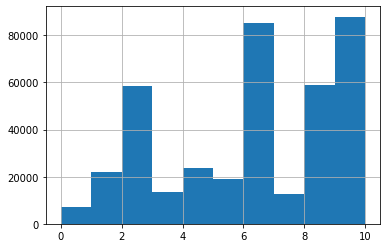

In [11]:
df_train['label'].hist() #imbalance problem #todo: add number on top? #todo: too much repeating datapoints

In [12]:
df_train_=df_train[['text','label']]
df_train_.drop_duplicates(subset ='text',keep = False, inplace = True) 
df_train_.head()

,text,label
0,Al funsiòuna da 'l 11 ed novèmber dal 2016.,0
1,Al 2017 'l è 'n an dal XXI sécol dal Calendàr...,0
2,Siligo i è un comun d'la Sardàggna d' 890 abit...,0
3,Valparaisol’é na cmûna e la capitèl d'l sud d'...,0
4,Queschè 'l è 'n elèinc di povéta ch'i àn scrìt...,0


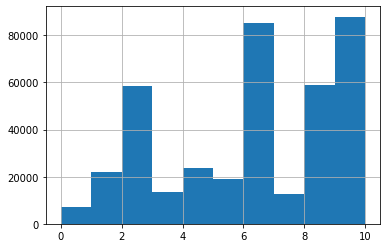

In [13]:
df_train_['label'].hist() #after remove duplicate, there is change in the distribution of the label 10

## Preprocessing - Tokenization


##### Tokenization 

Split the text into characters. Tokenizing in **character level**.

In [14]:
vocab = set()
for sent in df_train.text:
    for char in sent:
        vocab.add(char)

print("Total characters:", len(vocab))

Total characters: 987


In [15]:
# Map each item in the vocabulary to an index:
token_to_idx = {'<pad>': 0, '<unk>': 1}
for idx, token in enumerate(vocab, start=2):
    token_to_idx[token] = idx
idx_to_token = {idx: token for token, idx in token_to_idx.items()}

In [16]:
# Define encoding and decoding functions:
def encode_sent(sent):
    # sentence to token indices
    return [token_to_idx.get(token, token_to_idx['<unk>']) for token in sent]

def decode_sent(indices):
    # token indices to sentence
    return [idx_to_token[idx] for idx in indices]

def pad_truncate_sent(indices, max_length):
    # create a feature vector of max_length
    if len(indices) >= max_length:
        return indices[:max_length]
    return indices + [token_to_idx['<pad>']] * (max_length - len(indices))


#####  Prepare encoding the labels: assigning indexes to labels


In [17]:
# list of languages + unknown (e.g. not in the train set)
lang_list = final_lang.tolist() + ["<unk>"]

# language label to index
label_to_idx = {k: v for v, k in enumerate(lang_list)}

# index to language lable
idx_to_label = {v: k for k, v in label_to_idx.items()}

def encode_label(label):
    return label_to_idx.get(label, label_to_idx["<unk>"])

def decode_label(idx):
    return idx_to_label.get(idx, "<unk>")

##### Encoding data

Encode the data and labels.

In [18]:
def encode_dataset(data, max_len):
    encoded_data = []  # list of tuples (token-indices, label-idx)
    label_idx_list = [] #
    for index, row in data.iterrows():
        i = row.to_dict()
        token_indices = pad_truncate_sent(encode_sent(i['text']), max_len)
        label_idx = encode_label(i['label'])
        encoded_data.append((token_indices, label_idx))
        label_idx_list.append(label_idx)
    return encoded_data , label_idx_list

In [19]:
max_len = 50 #maximum len of a datapoint
encoded_trainset, label_idx_list = encode_dataset(df_train_, max_len=max_len) # label_idx_list

In [20]:
### ENCODING DEVSET
encoded_devset, label_idx_list_dev = encode_dataset(df_dev, max_len=max_len) 

### Load data 

In [21]:
from torch.utils.data.dataset import Dataset
class TextDataset(Dataset):

    def __init__(self, encoded_data):
        self.encoded_data = encoded_data

    def __getitem__(self, idx):
        token_idxs, label = self.encoded_data[idx]
        return torch.LongTensor(token_idxs), label
    
    def __len__(self):
        return len(self.encoded_data)

In [22]:
trainset = TextDataset(encoded_trainset)
valset = TextDataset(encoded_devset)

### Configure the GPU

In [23]:
print(torch.cuda.device_count())
print(torch.cuda.get_device_name(0))
cuda = torch.device('cuda')
device = cuda if torch.cuda.is_available() else 'cpu'

1
Tesla P100-PCIE-16GB


In [24]:
vocab_size = len(idx_to_token)
num_classes = len(label_to_idx)
print("Vocab size:", vocab_size)
print("Num classes:", num_classes)

Vocab size: 989
Num classes: 12


In [25]:
for i in range(1): print(trainset[i]) #todo: what is 5001? label?

(tensor([ 71, 394, 589, 580, 258,  47, 886, 894, 179, 258,  47, 707, 589, 303,
        707, 589, 913, 394, 589, 264, 264, 589, 603, 303, 589,  47,  84, 509,
        941, 442, 650, 603, 790, 589, 303, 707, 394, 589, 531, 839, 264, 676,
          4,   0,   0,   0,   0,   0,   0,   0]), 0)


# 2. Define the Convolutional Neural Network

In [26]:
from torch import nn
import math


class DialectIdentification(nn.Module):

    def __init__(self, vocab_size, embedding_size, max_len, num_classes, kernel_size, out_channels, stride, padding, dropout_rate, max_pool_size, cov2_kernel_size):
        super(DialectIdentification, self).__init__()

        self.out_channels = out_channels
        self.vocab_size = vocab_size
        self.embedding_size = embedding_size
        self.kernel_size = kernel_size
        self.stride = stride
        self.padding = padding
        self.in_channels = 1
        self.num_classes = num_classes
        self.dropout_rate = dropout_rate
        self.max_pool_size = max_pool_size
        self.cov2_kernel_size = cov2_kernel_size
        
        conv_1_out_shape_x = math.floor(((max_len + 2 * padding[0] - (kernel_size[0] - 1) - 1) / stride[0]) + 1)
        conv_1_out_shape_y = math.floor(((embedding_size + 2 * padding[1] - (kernel_size[1] - 1) - 1) / stride[1]) + 1)
        pool_1_out_shape_x = math.floor(((conv_1_out_shape_x + 2 * padding[0] - (max_pool_size[0] - 1) - 1) / stride[0]) + 1)
        pool_1_out_shape_y = math.floor(((conv_1_out_shape_y + 2 * padding[1] - (max_pool_size[1] - 1) - 1) / stride[1]) + 1)
        
        conv_2_out_shape_x = math.floor((((pool_1_out_shape_x + 2 * padding[0] - (cov2_kernel_size[0] - 1)) - 1) / stride[0]) + 1)
        conv_2_out_shape_y = math.floor((((pool_1_out_shape_y + 2 * padding[1] - (cov2_kernel_size[1] - 1)) - 1) / stride[1]) + 1)
        pool_2_out_shape_x = math.floor(((conv_2_out_shape_x + 2 * padding[0] - (max_pool_size[0] - 1) - 1) / stride[0]) + 1)
        pool_2_out_shape_y = math.floor(((conv_2_out_shape_y + 2 * padding[1] - (max_pool_size[1] - 1) - 1) / stride[1]) + 1)
        
        self.num_final_features = self.out_channels * pool_2_out_shape_x * pool_2_out_shape_y
        self.embeddings = nn.Embedding(vocab_size, embedding_size)
        self.conv2d = nn.Conv2d(in_channels=self.in_channels, out_channels=self.out_channels, kernel_size=self.kernel_size, stride=self.stride, padding=self.padding)
        self.max_pool2d = nn.MaxPool2d(kernel_size=max_pool_size, stride=self.stride, padding=self.padding)
        self.conv2d_2 = nn.Conv2d(in_channels=self.out_channels, out_channels=self.out_channels, kernel_size=self.cov2_kernel_size, stride=self.stride, padding=self.padding)
        self.max_pool2d_2 = nn.MaxPool2d(kernel_size=max_pool_size, stride=self.stride, padding=self.padding)
        self.linear = nn.Linear(self.num_final_features, self.num_classes)
    

    def forward(self, inputs):
        batchsize = inputs.size()[0]

        # (batch-size, max-len, emb-size)
        embeddings = self.embeddings(inputs)

        # reduce dimensionality of the embeddings
        embs_unsq = torch.unsqueeze(embeddings, 1)
        
        # 1st convolution and relu
        conv_out = nn.functional.relu(self.conv2d(embs_unsq))

        # 1st max pool
        pool_out = self.max_pool2d(conv_out)

        # 2nd max convolution and relu
        conv_2_out = nn.functional.relu(self.conv2d_2(pool_out))

        # 2nd max pooling
        pool_out_2 = self.max_pool2d_2(conv_2_out)

        # reshape 2d into a vector
        pool_out_2_reshaped = pool_out_2.view(-1, self.num_final_features)

        # dense layer and softmax
        lin_out = self.linear(F.dropout(pool_out_2_reshaped, self.dropout_rate))
        log_probs = nn.functional.log_softmax(lin_out, dim=1)
        return log_probs

# 3. Define the training function

In [27]:
#assigning weights for Negative Log-Likelihood function
from sklearn.utils.class_weight import compute_class_weight
class_weights = compute_class_weight(class_weight = "balanced", classes= np.unique(train_labels), y= train_labels)
'''import sklearn
class_weights = sklearn.utils.class_weight.compute_class_weight('balanced', np.unique(train_labels), train_labels) '''#calculating weight
#w_unk = class_weights[0:1] #add the weight of unk label by the weight of the fist label in the array (the label with high freq)
#w_unk = 3*class_weights[0:1]
w_unk = 100*class_weights[0:1]
class_weights_ = np.append(class_weights, w_unk) #now.. len = 12 = 11 + 1 = number_class + <unk> 
weights= torch.tensor(class_weights_,dtype=torch.float)
print("Weights of loss function:", weights)
loss_func = nn.NLLLoss(weight=weights)

Weights of loss function: tensor([5.0133e+00, 1.5996e+00, 6.0311e-01, 2.6030e+00, 1.4827e+00, 1.8469e+00,
        4.1535e-01, 2.8071e+00, 5.9991e-01, 6.5357e-01, 1.0456e+00, 5.0133e+02])


In [28]:
import torch.optim as optim
from torch.optim.lr_scheduler import StepLR
from sklearn.metrics import f1_score, accuracy_score
import matplotlib.pyplot as plt
import torch.nn.functional as F

def get_data(config, data):
  data_loaded = DataLoader(
    data,
    batch_size=config["batch_size"],
    shuffle=True,
    drop_last=True)
  return data_loaded

def get_loss(model, data_loader):
    losses = []
    model.eval()
    with torch.no_grad():
        for token_ids, label_ids in data_loader:
            token_ids = token_ids.to(device)
            label_ids = label_ids.to(device)
            y_pred = model(token_ids)
            loss = loss_func(y_pred, label_ids)
            loss_batch = loss.item()
            losses.append(loss_batch)
    return np.mean(losses)
#loss_func = nn.NLLLoss(weight=weights).to(device) #use for loss_weights
loss_func = nn.NLLLoss()
def train_model(model, optimizer, scheduler, loss_func, device, num_epochs, dev_loader, val_loader):
    dev_loss = []
    val_loss = []
    for epoch in range(1, num_epochs + 1):
        model.train()
        losses = []
        batch_num = 0
        for token_ids, label_ids in dev_loader:
            batch_num += 1
            token_ids = token_ids.to(device)
            label_ids = label_ids.to(device)
            optimizer.zero_grad()
            y_pred = model(token_ids)
            loss = loss_func(y_pred, label_ids)
            loss_batch = loss.item()
            loss.backward()
            optimizer.step()
            losses.append(loss_batch)
        avg_loss = np.mean(losses[-10:])
        print(f'Epoch {epoch}/{num_epochs}, avg. loss: {avg_loss:.4f}, lr: {scheduler.get_last_lr()[0]}')
        scheduler.step()

        # evaluate the model after each epoch
        dev_loss.append(get_loss(model, dev_loader))
        val_loss.append(get_loss(model, val_loader))
    return dev_loss, val_loss

def train_config(config, trainset, valset):
    dev_loader = get_data(config, trainset)
    val_loader = get_data(config, valset)
    num_epochs = config["num_epochs"]
    model = DialectIdentification(
        vocab_size,
        config["embedding_size"],
        max_len,
        num_classes,
        config["kernel_size"],
        config["out_channels"],
        config["stride"],
        config["padding"],
        config["dropout"],
        config["max_pool_size"],
        config["cov2_kernel_size"]
    ) 
    model.to(device)
    # training parameters
    #loss_func = nn.NLLLoss(weight=weights).to(device)
    loss_func = nn.NLLLoss()
    lr = config["lr"]
    #optimizer = optim.SGD(model.parameters(), lr=lr, momentum=0.9)
    optimizer = optim.Adam(model.parameters(), lr=lr)
    scheduler = optim.lr_scheduler.StepLR(optimizer, step_size=10, gamma=0.5)
    dev_loss, val_loss = train_model(
        model,
        optimizer, 
        scheduler,
        loss_func,
        device,
        num_epochs,
        dev_loader,
        val_loader)

    plt.figure()
    plt.title("Loss")
    plt.plot(list(range(num_epochs)), dev_loss, label="train")
    plt.plot(list(range(num_epochs)), val_loss, label="validation")
    plt.xlabel("Epochs")
    plt.legend()
    plt.show()
    return model


## 4. Define the evaluation function

In [29]:
def evaluate_model(config, model, data):
    data_loader = get_data (config,data)
    predicted = []
    gold = []
    model.eval()
    with torch.no_grad():
        for token_ids, label_ids in data_loader:
            token_ids = token_ids.to(device)
            label_ids = label_ids.to(device)
            log_probs = model(token_ids)
            y_pred = log_probs.argmax(dim=1)
            predicted.extend([i.item() for i in y_pred])
            gold.extend(label_ids.cpu().numpy())
    accuracy = accuracy_score(gold, predicted)
    f1_macro = f1_score(gold, predicted, average='macro')
    return accuracy, f1_macro

## 5. Train the networks

Epoch 1/10, avg. loss: 0.2526, lr: 0.001000323475861476
Epoch 2/10, avg. loss: 0.2301, lr: 0.001000323475861476
Epoch 3/10, avg. loss: 0.2006, lr: 0.001000323475861476
Epoch 4/10, avg. loss: 0.2563, lr: 0.001000323475861476
Epoch 5/10, avg. loss: 0.1748, lr: 0.001000323475861476
Epoch 6/10, avg. loss: 0.2393, lr: 0.001000323475861476
Epoch 7/10, avg. loss: 0.1618, lr: 0.001000323475861476
Epoch 8/10, avg. loss: 0.2276, lr: 0.001000323475861476
Epoch 9/10, avg. loss: 0.1739, lr: 0.001000323475861476
Epoch 10/10, avg. loss: 0.1038, lr: 0.001000323475861476


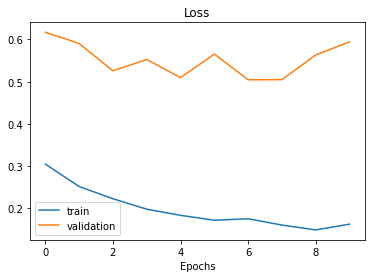

Traning (acc, f1):  (0.9529127911762285, 0.9471826816660621)
Validating (acc, f1):  (0.8525943396226415, 0.5474233217516221)


In [34]:
#@tittle: model 1
#optimizer: Adam #loss_weights: yes, w_unk = 3*w_ar
config1 = {
    "embedding_size": 512,
    "max_pool_size": (6, 12),
    "kernel_size": (3, 3),
    "out_channels": 16,
    "stride": (2, 1),
    "padding": (1, 0),
    "dropout": 0.2,
    "lr": 0.001000323475861476,
    "num_epochs": 10,
    "cov2_kernel_size": (6, 6),
    "batch_size": 32}
model1 = train_config(config1, trainset, valset)
print("Traning (acc, f1): ", evaluate_model(config1, model1, trainset))
print("Validating (acc, f1): ", evaluate_model(config1, model1, valset))

- We encoded tweet in character-level with different embedding sizes. However, single character, i.e. 1-gram, is the only way encoded the text. Meanwhile, by using Scikit-learn for classifiers models, we encoded texts with different configurations including word levels, character level and character within boundary of word level. 
- CNN might be more complicated than classifier methods to handle our dataset. In general, a powerful model has tendency to treat simple problem with complicated architecture. This leads to over-fitting issue which indicates that our model is too complex for the problem that it is solving. As consequence, the model resulting from CNN performs badly on the unseen data.

## Performance on the Test set
`` now we use the trained model to predict data on test set and observe how well the model performs.``

In [35]:
 #model summary
model1 

DialectIdentification(
  (embeddings): Embedding(989, 512)
  (conv2d): Conv2d(1, 16, kernel_size=(3, 3), stride=(2, 1), padding=(1, 0))
  (max_pool2d): MaxPool2d(kernel_size=(6, 12), stride=(2, 1), padding=(1, 0), dilation=1, ceil_mode=False)
  (conv2d_2): Conv2d(16, 16, kernel_size=(6, 6), stride=(2, 1), padding=(1, 0))
  (max_pool2d_2): MaxPool2d(kernel_size=(6, 12), stride=(2, 1), padding=(1, 0), dilation=1, ceil_mode=False)
  (linear): Linear(in_features=7728, out_features=12, bias=True)
)

In [36]:
#encoded_test_set,_ = encode_dataset(df_test, max_len=max_len)
#testset = TweetDataset(encoded_test_set)
print("Test (acc, f1): ", evaluate_model(config1, model1, valset))

Test (acc, f1):  (0.8555424528301887, 0.548081347745748)


In [33]:
#todo: Tuning hyper params RayTune
#todo: data augmentation